In [2]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' ))

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load a case (its segmentation and strain)

In [3]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]

patient_index = 4

In [4]:
# first: get the ED and ES frame
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(patient_id, ED,ES)

save_folder = os.path.join(main_path, 'results/strain/', patient_id)
ff.make_folder([save_folder])

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/fine_tune_carson/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
new_M_ED = np.zeros_like(M_ED)
new_M_ED[M_ED_RV==3] = 1
new_M_ED[M_ED==1] = 3
new_M_ED[M_ED==2] = 2
M_nifti_ED = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
new_M_ES = np.zeros_like(M_ES)
new_M_ES[M_ES_RV==3] = 1
new_M_ES[M_ES==1] = 3
new_M_ES[M_ES==2] = 2
M_nifti_ES = nb.Nifti1Image(new_M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)


# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))
print('after concat, shape: ,', V_nifti.shape)

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
print('after resample, shape: ', V_nifti.shape, M_nifti.shape)

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
print('after crop, shape: ', V.shape, M.shape, ' Labels: ', np.unique(M))

# 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))
print('before input into the model, the shape: ', V_0.shape, V_t.shape)

# fifth: predict motion vector
y_t = nb.load(os.path.join(main_path, 'results/trained/mvf', patient_id, 'mvf_ED_ES.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

# last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]

# calculate strain
strain = myocardial_strain_zc.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)
strain_es = myocardial_strain_zc.MyocardialStrain(mask=mask_end_systole, flow=y_t[0,:,:,:,:])
strain_es.calculate_strain(lv_label=2)

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())

# plt.figure(figsize=(10,5))
# plt.subplot(121); plt.imshow(strain.Err[:,:,5], cmap='RdBu'); plt.title('Global Radial Strain'); plt.colorbar()
# plt.subplot(122); plt.imshow(strain.Ecc[:,:,5], cmap='RdBu_r'); plt.title('Global Circumferential Strain'); plt.colorbar()
# plt.show() 


ID_0685 1 8
after concat, shape: , (216, 256, 18, 2)
after resample, shape:  (230, 272, 16, 2) (230, 272, 16, 2)
after crop, shape:  (128, 128, 16, 2) (128, 128, 16, 2)  Labels:  [0. 1. 2. 3.]
before input into the model, the shape:  (1, 128, 128, 16) (1, 128, 128, 16)
y_t shape:  (1, 128, 128, 16, 3)
Radial strain:  20.160747820690577
Circumferential strain:  -14.939155773817383


Text(0.5, 1.0, 'Cine-MRI Mask at End-Systole')

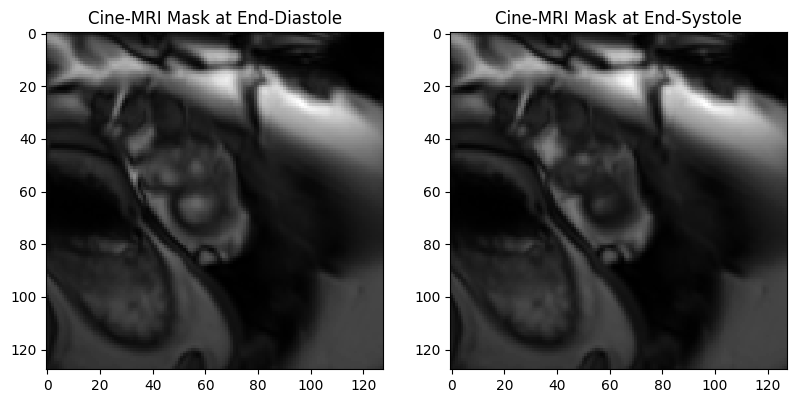

In [4]:
plt.figure(figsize=(20,10))
plt.subplot(143); plt.imshow(V[:,:,14,0], cmap='gray'); plt.title('Cine-MRI Mask at End-Diastole')
plt.subplot(144); plt.imshow(V[:,:,14,1], cmap='gray'); plt.title('Cine-MRI Mask at End-Systole')

# Step 1: define the RV insertion point

(128, 128, 16) [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
(128, 128, 16) [7, 8, 9, 10, 11, 12, 13, 14]
10
base
[[40 82]
 [57 43]]
phi_angle:  101.2735564907135


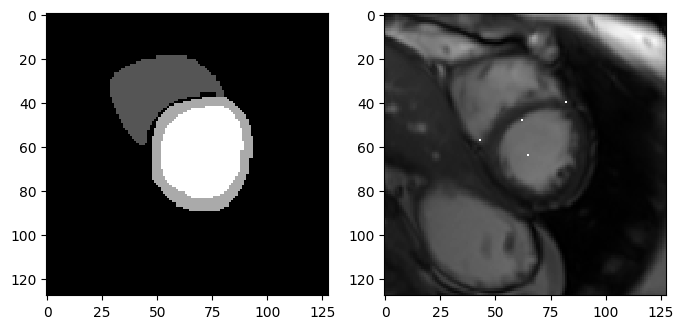

In [5]:
V_ed = V[:,:,:,0]

# define mid slice
# find the nonzero slices in the strain.mask
slice_nonzero_ed = [i for i in range(strain.mask.shape[2]) if np.sum(strain.mask[:,:,i])>0]
slice_nonzero_es = [i for i in range(strain_es.mask.shape[2]) if np.sum(strain_es.mask[:,:,i])>0]
# middle_slice
mid_slice = slice_nonzero_ed[len(slice_nonzero_ed)//2]
print(strain.mask.shape, slice_nonzero_ed)
print(strain_es.mask.shape, slice_nonzero_es)
print(mid_slice)

# find out it starts from apex or base
start_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[1]]); start_slice[start_slice >0] = 1
end_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[-1 - 2]]); end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start_slice_name = 'apex'
else:
    start_slice_name = 'base'
print(start_slice_name)


# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(strain.mask[:,:,mid_slice], cmap='gray')
if os.path.isfile(os.path.join(save_folder, 'insertion_points.npy')):
    insertion_points = np.load(os.path.join(save_folder, 'insertion_points.npy'))
    insertion_p1 = insertion_points[0,:]
    insertion_p2 = insertion_points[1,:]
else:
    # from the figure, we define the RV insertion points
    insertion_p1 = [38,80]
    insertion_p2 = [67,38]
    # make insertion_p1 and p2 as a 2x2 numpy array
    insertion_points = np.vstack((np.asarray(insertion_p1), np.asarray(insertion_p2)))
    # save the insertion points
    # np.save(os.path.join(save_folder, 'insertion_points.npy'), insertion_points)
print(insertion_points)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)

# plot
ii = np.copy(V_ed[:,:,mid_slice])
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


# Step 2: Rotate Data

[7, 8, 9, 10, 11, 12, 13, 14]


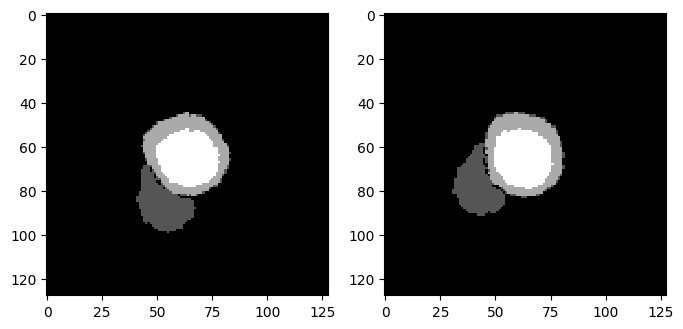

In [13]:
# rotate the data so that RV is under LV
rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain.mask, insertion_p1, insertion_p2, non_slice_num = slice_nonzero_es )
Err_rot, Ecc_rot, mask_rot, ID = rotate_f.rotate_orientation(for_visualization=False)
Err_rot_vis, Ecc_rot_vis, mask_rot_vis, ID = rotate_f.rotate_orientation(for_visualization=True)

rotate_f_es = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc, strain_es.mask, insertion_p1, insertion_p2, non_slice_num = slice_nonzero_es )
Err_rot_es, Ecc_rot_es, mask_rot_es, ID = rotate_f_es.rotate_orientation(for_visualization=False)

print(ID)
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(mask_rot[:,:,5], cmap='gray')
plt.subplot(122); plt.imshow(mask_rot_vis[:,:,5], cmap='gray')

In [15]:
# find out which slices need to use segmentation of Err
need_recal_slice_index = []
for j in range(strain.Err.shape[-1]):
    a = strain.Err[:,:,j]
    a = a[strain.mask_rot[:,:,j]==2] * 100
    if np.mean(a)<1:
        print('this slice needs to use segmentation of Err: ', j)
        need_recal_slice_index.append(j)
need_recal_slice_index.append([1])
# find out the index of j in ID:
need_recal_slice_index = [ID.index(i)  if i in ID else None for i in need_recal_slice_index]
print(need_recal_slice_index)

this slice needs to use segmentation of Err:  13
this slice needs to use segmentation of Err:  14
[6, 7, None]


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
class wall_thickness_change_index():
   def __init__(self, mask_rot, mask_rot_es):       
      self.mask_tf1  = mask_rot
      self.mask_tf2  = mask_rot_es

   def calculate_strain(self):
      # prepare data
      E = np.copy(self.mask_tf1)
      E_es = np.copy(self.mask_tf2)

      # get len change
      len_change_tf1 = self.calculate_len_change(E)
      len_change_tf2 = self.calculate_len_change(E_es)

      strain_by_seg = np.zeros(len_change_tf1.shape)
      for i in range(len_change_tf1.shape[0]):
         for j in range(len_change_tf1.shape[1]):
            strain_by_seg[i,j] += (len_change_tf2[i,j,0] - len_change_tf1[i,j,0])/len_change_tf1[i,j,0]
         
      return strain_by_seg

      
   def calculate_len_change(self, E):
      '''E should be equal to np.copy(self.mask_tf)'''
      # prepare data
      E = E.transpose((2,0,1))

      # prepare angles and radians
      nz = E.shape[0]
      angles = np.arange(0, 360, 1)
      len_change = np.zeros((nz, angles.shape[0], 100))

      for rj in range(nz):
         # find the center of mass
         m = np.copy(self.mask_tf1[:,:,rj])
         cx, cy = center_of_mass(m>=2)  

         # find the slice
         E_rj = E[rj]
         E_rj = roll_to_center(E_rj, cx, cy)

         Err_q  = _inpter2(E_rj)
         Err_q[abs(Err_q - 2) < 0.3] = 2 # stablize

         PHI, _ = _polar_grid(*Err_q.shape) # *Err_q.shape as well as PHI and R = (1280, 1280)
         PHI = PHI.ravel() # flatten

         for k, pmin in enumerate(angles):
            pmax = pmin + 3 # 3 for stablization
            PHI_SEGMENT = (PHI>=pmin)&(PHI<=pmax)
            PHI_SEGMENT = np.reshape(PHI_SEGMENT, (1280, 1280))

            points = np.where(PHI_SEGMENT==True)

            # let's find out several boundary points
            # first, in "points", which point is the cloest to the [cx, cy]
            dis = np.sqrt((points[0]-cx * 10)**2 + (points[1]-cy * 10)**2)
            dis_index = np.argsort(dis)
            innest_point = points[0][dis_index[0]], points[1][dis_index[0]]

            # second, let's find out which points in "points" have value equal to 2 in Err_q
            points_value = Err_q[points[0], points[1]]
            points_value_index = np.where(points_value==2)
            points_value_index = points_value_index[0]
            points_w_2 = points[0][points_value_index], points[1][points_value_index]

            # third, find out in points_w_2, which point is the cloest to the innest_point
            dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
            dis_index = np.argsort(dis)
            start_point = points_w_2[0][dis_index[0]], points_w_2[1][dis_index[0]]

            # fourth, find out in points_w_2, which point is further to the innest_point
            dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
            dis_index = np.argsort(dis)
            end_point = points_w_2[0][dis_index[-1]], points_w_2[1][dis_index[-1]]

            # fifth, calculat the euclidean distance between start_point and end_point
            dis = np.sqrt((start_point[0]-end_point[0])**2 + (start_point[1]-end_point[1])**2)

            # plot if needed
            # plt.figure(figsize=(8,4))
            # plt.subplot(121); plt.imshow(Err_q, cmap='gray')
            # PHI = np.reshape(PHI, (1280, 1280))
            # Err_q[innest_point[0] :innest_point[0] + 5 , innest_point[1] : innest_point[1] +5] = 5
            # Err_q[start_point[0] :start_point[0] + 5 , start_point[1] : start_point[1] +5] = 5
            # Err_q[end_point[0] :end_point[0] + 5 , end_point[1] : end_point[1] +5] = 5
            # plt.subplot(122); plt.imshow(Err_q , cmap='gray')

            len_change[rj,k] += dis

      return len_change 
   
   def construct_AHA_map(self, tensor, start_slice_name, sigma = 12):

        E  = tensor.copy()
        mu = E[:,:,:].mean()

        nz = E.shape[0]
        E  = np.concatenate(np.array_split(E[:,:,:], nz), axis=-1)[0] # stack the slices together,  shape (360, (stop - start) * slice_num)

        old = E.shape[1]/nz*1. # original R (stop - start)
        for j in range(nz-1):
            xi = int(old//2+j*old)
            xj = int(old+old//2+j*old)
            E[:,xi:xj] = gaussian_filter(E[:,xi:xj],sigma=sigma, mode='wrap')
            E[:,xi:xj] = gaussian_filter(E[:,xi:xj],sigma=sigma, mode='wrap')

        E = np.stack(np.array_split(E,nz,axis=1)) # put into original shape

        # divide into apical, mid and basal layers
        slices_per_layer = E.shape[0]//3
        if start_slice_name == 'apex':
            layer1 = E[0:slices_per_layer,...]
            layer2 = E[slices_per_layer : slices_per_layer * 2 + 1,...]
            layer3 = E[slices_per_layer * 2 + 1: E.shape[0],...]
        
        else: # start from "base"
            layer1 = E[E.shape[0] - slices_per_layer :E.shape[0],...]
            layer2 = E[E.shape[0] - slices_per_layer * 2 -1 : E.shape[0] - slices_per_layer,...]
            layer3 = E[0: E.shape[0] - slices_per_layer * 2 -1,...]

        E = [layer1, layer2, layer3]  ######### apical, mid, basal
        print('layer1, layer2, layer3: ', layer1.shape, layer2.shape, layer3.shape)

        E = [np.mean(E[i], axis=0) for i in range(3)] # calculate mean across all slices in each layer
        print('E: ', E[0].shape, E[1].shape, E[2].shape)
        E = np.concatenate(E, axis=1)  # shape (360, 3 * (stop - start))
        print(E.shape)

        mu = [mu] + self._get_16segments(E) +[0]

        return E, mu 
    
   def _get_16segments(self, data):
        c2,c3,c4 = np.array_split(data,3,axis=-1)

        c4 = [np.mean(ci) for ci in np.array_split(c4,6,axis=0)]  # basal
     
        c3 = [np.mean(ci) for ci in np.array_split(c3,6,axis=0)]  # mid

        c2 = [np.mean(ci) for ci in np.array_split(c2,4,axis=0)]  # apical

        c = c4 + c3 + c2 
        return c

In [17]:
by_seg = wall_thickness_change_index(mask_rot, mask_rot_es)
strain_by_seg = by_seg.calculate_strain()

In [18]:
E_seg,mu_seg = by_seg.construct_AHA_map(strain_by_seg, start_slice_name)

layer1, layer2, layer3:  (2, 360, 100) (3, 360, 100) (3, 360, 100)
E:  (360, 100) (360, 100) (360, 100)
(360, 300)


(11, 128, 128)
dis:  26.832815729997478


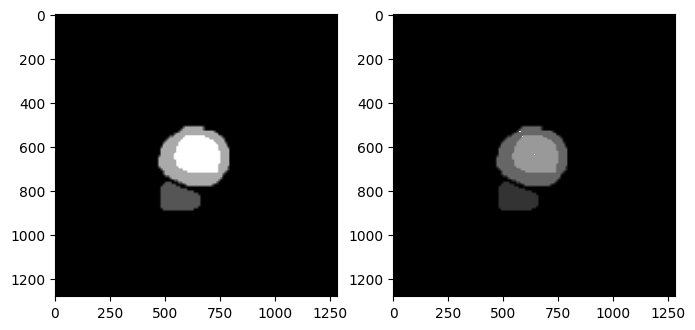

In [103]:
rj = 1
pmin = 30

E = np.copy(mask_rot)
E = E.transpose((2,0,1))
print(E.shape)

# rolls to center
m = np.copy(mask_rot[:,:,rj])
cx, cy = center_of_mass(m>=2)

nz = E.shape[0]
angles = np.arange(0, 360, 1)
V      = np.zeros((nz, angles.shape[0], 100))

E_rj = E[rj]
E_rj = roll_to_center(E_rj, cx, cy)
Err_q  = _inpter2(E_rj)
Err_q[abs(Err_q - 2) < 0.3] = 2


PHI, R = _polar_grid(*Err_q.shape) # *Err_q.shape as well as PHI and R = (1280, 1280)
PHI = PHI.ravel() # flatten
R   = R.ravel()

pmax = pmin + 3 # 0.5 increment

# Get values for angle segment

PHI_SEGMENT = (PHI>=pmin)&(PHI<=pmax)
PHI_SEGMENT = np.reshape(PHI_SEGMENT, (1280, 1280))

points = np.where(PHI_SEGMENT==True)

# let's find out several boundary points
# first, in "points", which point is the cloest to the [cx, cy]
dis = np.sqrt((points[0]-cx * 10)**2 + (points[1]-cy * 10)**2)
dis_index = np.argsort(dis)
innest_point = points[0][dis_index[0]], points[1][dis_index[0]]

# second, let's find out which points in "points" have value equal to 2 in Err_q
points_value = Err_q[points[0], points[1]]
points_value_index = np.where(points_value==2)
points_value_index = points_value_index[0]
points_w_2 = points[0][points_value_index], points[1][points_value_index]

# third, find out in points_w_2, which point is the cloest to the innest_point
dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
dis_index = np.argsort(dis)
start_point = points_w_2[0][dis_index[0]], points_w_2[1][dis_index[0]]

# fourth, find out in points_w_2, which point is further to the innest_point
dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
dis_index = np.argsort(dis)
end_point = points_w_2[0][dis_index[-1]], points_w_2[1][dis_index[-1]]

# fifth, calculat the euclidean distance between start_point and end_point
dis_original = np.sqrt((start_point[0]-end_point[0])**2 + (start_point[1]-end_point[1])**2)
print('dis: ', dis_original)


plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(Err_q, cmap='gray')
PHI = np.reshape(PHI, (1280, 1280))
Err_q[innest_point[0] :innest_point[0] + 5 , innest_point[1] : innest_point[1] +5] = 5
Err_q[start_point[0] :start_point[0] + 5 , start_point[1] : start_point[1] +5] = 5
Err_q[end_point[0] :end_point[0] + 5 , end_point[1] : end_point[1] +5] = 5
plt.subplot(122); plt.imshow(Err_q , cmap='gray')

(10, 128, 128)
dis:  102.62553288534
strain:  2.824627795979339


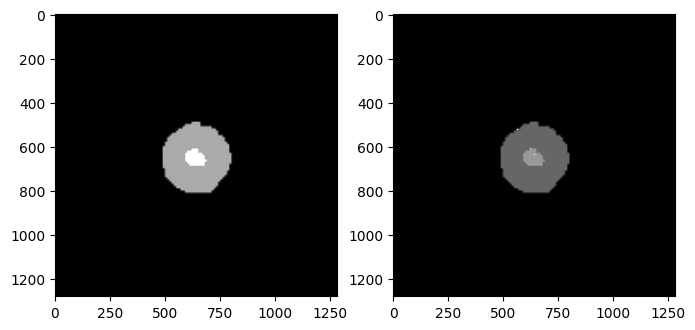

In [104]:
rj = 0
E = np.copy(mask_rot_es)
E = E.transpose((2,0,1))
print(E.shape)

dphi = 1
angles = np.arange(0, 360, 1)

E_rj = E[rj]
E_rj = roll_to_center(E_rj, cx, cy)
Err_q  = _inpter2(E_rj)
Err_q[abs(Err_q - 2) < 0.3] = 2


PHI, R = _polar_grid(*Err_q.shape) # *Err_q.shape as well as PHI and R = (1280, 1280)
PHI = PHI.ravel() # flatten
R   = R.ravel()

pmax = pmin + 3 # 0.5 increment

# Get values for angle segment

PHI_SEGMENT = (PHI>=pmin)&(PHI<=pmax)
PHI_SEGMENT = np.reshape(PHI_SEGMENT, (1280, 1280))

points = np.where(PHI_SEGMENT==True)

# let's find out several boundary points
# first, in "points", which point is the cloest to the [cx, cy]
dis = np.sqrt((points[0]-cx * 10)**2 + (points[1]-cy * 10)**2)
dis_index = np.argsort(dis)
innest_point = points[0][dis_index[0]], points[1][dis_index[0]]

# second, let's find out which points in "points" have value equal to 2 in Err_q
points_value = Err_q[points[0], points[1]]
points_value_index = np.where(points_value==2)
points_value_index = points_value_index[0]
points_w_2 = points[0][points_value_index], points[1][points_value_index]

# third, find out in points_w_2, which point is the cloest to the innest_point
dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
dis_index = np.argsort(dis)
start_point = points_w_2[0][dis_index[0]], points_w_2[1][dis_index[0]]

# fourth, find out in points_w_2, which point is further to the innest_point
dis = np.sqrt((points_w_2[0]-innest_point[0])**2 + (points_w_2[1]-innest_point[1])**2)
dis_index = np.argsort(dis)
end_point = points_w_2[0][dis_index[-1]], points_w_2[1][dis_index[-1]]

# fifth, calculat the euclidean distance between start_point and end_point
dis_last = np.sqrt((start_point[0]-end_point[0])**2 + (start_point[1]-end_point[1])**2)
print('dis: ', dis_last)


# print strain
delta = (dis_last - dis_original) / dis_original
print('strain: ', delta)

V[rj, 0] += delta

plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(Err_q, cmap='gray')
PHI = np.reshape(PHI, (1280, 1280))
Err_q[innest_point[0] :innest_point[0] + 5 , innest_point[1] : innest_point[1] +5] = 5
Err_q[start_point[0] :start_point[0] + 5 , start_point[1] : start_point[1] +5] = 5
Err_q[end_point[0] :end_point[0] + 5 , end_point[1] : end_point[1] +5] = 5
plt.subplot(122); plt.imshow(Err_q , cmap='gray')



# Step 3: Polar Sampling

In [9]:
from scipy.interpolate import interp1d, interp2d
def roll(x, rx, ry):
    x = np.roll(x, rx, axis=0)
    return np.roll(x, ry, axis=1)

def roll_to_center(x, cx, cy):
    nx, ny = x.shape[:2]
    return roll(x,  int(nx//2-cx), int(ny//2-cy))

def _inpter2(Eij, k=10):
    nx, ny = Eij.shape
    
    x  = np.linspace(0,nx-1,nx)
    y  = np.linspace(0,ny-1,ny)
    xq = np.linspace(0,nx-1,nx*k)
    yq = np.linspace(0,ny-1,ny*k)

    f = interp2d(x,y,Eij,kind='linear')
    
    return f(xq,yq) 

def _polar_grid(nx=128, ny=128):
    x, y = np.meshgrid(np.linspace(-nx//2, nx//2, nx), np.linspace(-ny//2, ny//2, ny))
    phi  = (np.rad2deg(np.arctan2(y, x)) + 180).T
    r    = np.sqrt(x**2+y**2+1e-8)
    return phi, r

def _rescale_linear(array, new_min, new_max):
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max-new_min) / (maximum-minimum)
    b = new_min - m* minimum
    return m*array + b

class PolarMap():
    
    def __init__(self, Err, Ecc, mask):       
        self.Err  = Err
        self.Ecc  = Ecc
        self.mask = mask

    def project_to_aha_polar_map(self):

        Err = self.Err.transpose((2,0,1))
        Ecc = self.Ecc.transpose((2,0,1))
        print('... radial strain')
        V_err = self._project_to_aha_polar_map(Err)
        print('... circumferential strain')
        V_ecc = self._project_to_aha_polar_map(Ecc)

        results = {'V_err':V_err, 'V_ecc':V_ecc, 'mask':self.mask}

        return results
        
    def _project_to_aha_polar_map(self, E, nphi=360, nrad=100, dphi=1):
        
        nz = E.shape[0]
        angles = np.arange(0, nphi, dphi)
        V      = np.zeros((nz, angles.shape[0], nrad))

        for rj in range(nz):
            
            m = np.copy(self.mask[:,:,rj])
            cx, cy = center_of_mass(m==2)

            E_rj = E[rj]
            E_rj = roll_to_center(E_rj, cx, cy) # center the image
            Err_q  = _inpter2(E_rj)

            # Err_q  = _inpter2(E[rj]) # increase size by 10

            PHI, R = _polar_grid(*Err_q.shape) # *Err_q.shape as well as PHI and R = (1280, 1280)
            PHI = PHI.ravel() # flatten
            R   = R.ravel()

            for k, pmin in enumerate(angles):
                pmax = pmin + 3#dphi/2.0 # 0.5 increment

                # Get values for angle segment
                PHI_SEGMENT = (PHI>=pmin)&(PHI<=pmax)
                Rk   = R[PHI_SEGMENT]
               
                PHIk = PHI[PHI_SEGMENT]
                Vk   = Err_q.ravel()[PHI_SEGMENT]
                
                # only use the one with non-zero values in Rk and Vk
                Rk = Rk[np.abs(Vk)!=0]
                Vk = Vk[np.abs(Vk)!=0]

                
                if len(Vk) == 0 or len(Vk) == 1:
                    continue # this might not be the best
                Rk = _rescale_linear(Rk, rj, rj + 1)  #scale Rk into 0 to 1

                r = np.arange(rj, rj+1, 1.0/nrad)  # divide Rk into nrad parts
                
                f = interp1d(Rk, Vk) # need to interpolate Vk using the known Vk in Rk
                v = f(r)

                V[rj,k] += v

        return V  

In [88]:
polar =PolarMap(Err_rot, Ecc_rot, mask_rot)
polar_result = polar.project_to_aha_polar_map()


... radial strain


... circumferential strain


In [89]:
polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)

In [90]:
Ecc_polar, Ecc_mu = polar.construct_AHA_map(polar_result['V_ecc'], start_slice_name = start_slice_name, start = 20, stop = 80)
Err_polar, Err_mu = polar.construct_AHA_map(polar_result['V_err'], start_slice_name = start_slice_name, start = 20, stop = 80)


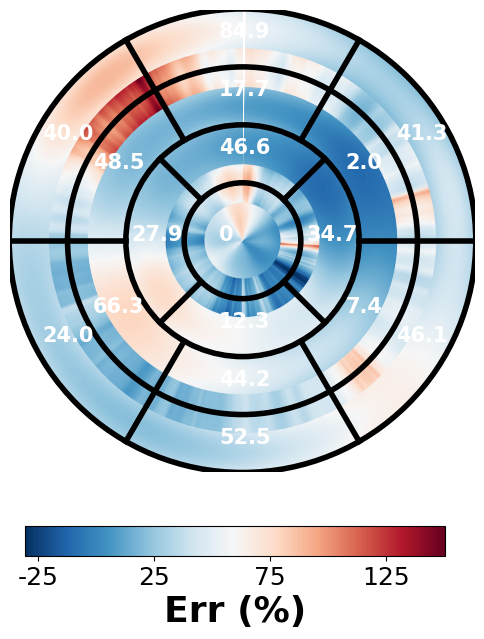

In [19]:
myocardial_strain_zc.plot_bullseye(E_seg,mu_seg[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='Err (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

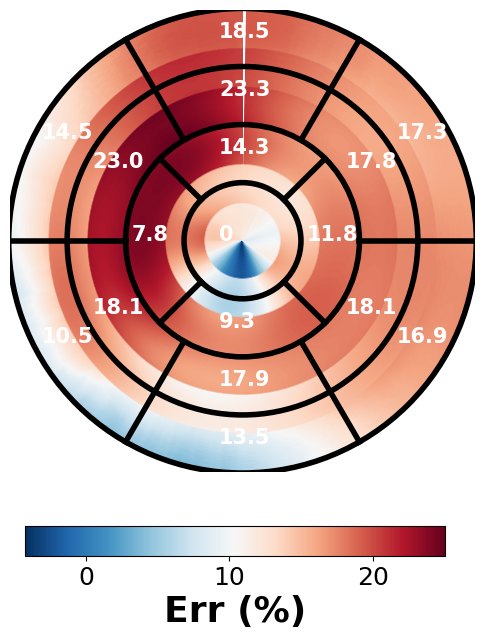

In [92]:
myocardial_strain_zc.plot_bullseye(Err_polar,Err_mu[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu_r', label='Err (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

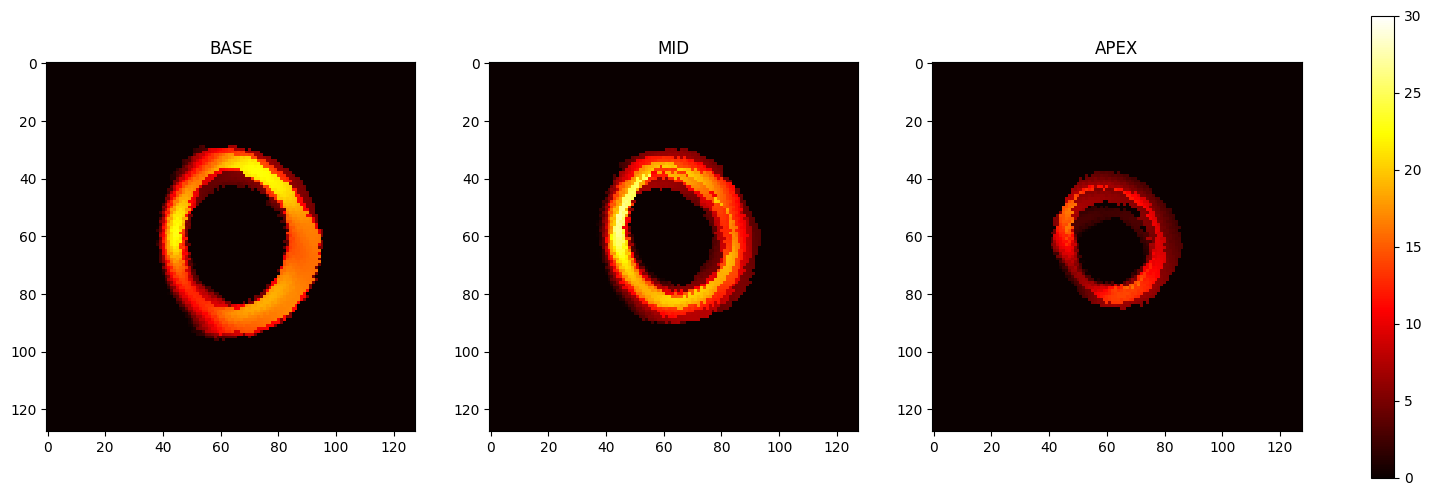

In [38]:
norm = Normalize(vmin=0, vmax=30)

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1,1])

color = 'hot'
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(np.mean(Err_rot_vis[:,:,7:10] * 100, axis = -1), cmap=color, norm=norm)
ax1.set_title('BASE')

ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(np.mean(Err_rot_vis[:,:,3:7] * 100, axis = -1), cmap=color, norm=norm)
ax2.set_title('MID')

ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(np.mean(Err_rot_vis[:,:,0:3] * 100, axis = -1), cmap=color, norm=norm)
ax3.set_title('APEX')

# Add colorbar
fig.colorbar(im3, ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05, pad=0.05)

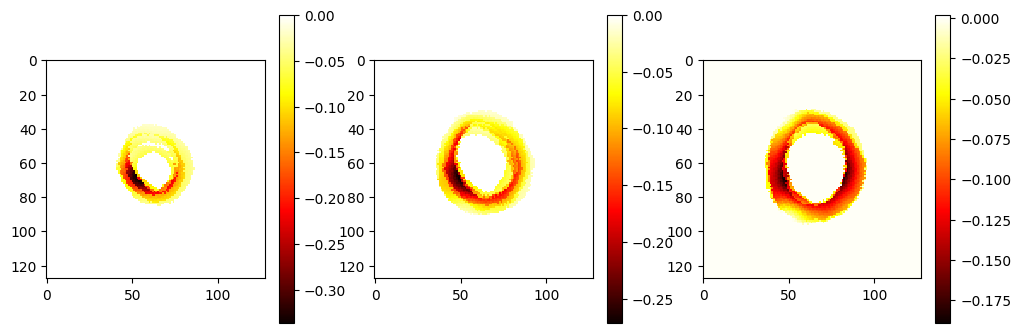

In [26]:
plt.figure(figsize=(12,4));
plt.subplot(131); plt.imshow(np.mean(Ecc_rot_vis[:,:,0:3], axis = -1), cmap='hot'); plt.colorbar()
plt.subplot(132); plt.imshow(np.mean(Ecc_rot_vis[:,:,3:7], axis = -1), cmap='hot'); plt.colorbar()
plt.subplot(133); plt.imshow(np.mean(Ecc_rot_vis[:,:,7:10], axis = -1), cmap='hot'); plt.colorbar()
